### Модел 1: Отстапувања од вредноста на контролата

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

#### Поставување на влезен/излезен folder

In [9]:
plot_out = '../plots/03_m1_mse'

if not os.path.exists(plot_out):
    os.makedirs(plot_out)

#### Читање на влезните податоци

In [10]:
df = pd.read_csv('../data/dataset/Spenser_1_8_new_format_on_PE_markers.tsv', sep='\t')

# Отстранување на редиците каде нема ниту една вредност за 'SAPECoeficient', 'APECoeficient', 'FPECoeficient'
valid_indices = df.index[(df.notna()['SAPECoeficient'] | \
                          df.notna()['APECoeficient'] | \
                          df.notna()['FPECoeficient'])]
df['TERRID'] = df['TERRID'].str.replace('Employee ', '')
df = df.iloc[valid_indices]

# Приказ
df[::len(df)//10]

,CustomerID,Calendarday,month,PerformanceEvaluationPlanned,PerformanceEvaluationExecuted,ExternalEvaluation,TERRID,SAPECCSalesGroup,SAPECoeficient,APECoeficient,FPECoeficient,SAMEDAYVISIT,OVERDUE,UNDERDUE,OK,NOTOK,STATUS,OVERDUEDAYS
1,100000136,2017-05-04,5,1,1,0,44,Team 1,90.987,NaN,90.987,,,,,,,
13979,100001198,2017-06-24,6,0,0,1,6,Team 8,NaN,65.050,73.783,,,,,,,
28224,100002467,2017-06-21,6,1,1,0,5,Team 8,24.185,NaN,24.185,,,,ok,,ok,
41553,100003788,2017-12-22,12,1,1,0,60,Team 7,93.463,NaN,94.066,,,,,,,
55455,100005167,2017-11-24,11,1,1,0,47,Team 4,66.746,NaN,66.746,,,,,,,
69401,100006770,2017-08-01,8,1,1,0,24,Team 11,24.575,NaN,24.575,,,,,,,
83346,100008926,2017-06-15,6,1,1,0,65,Team 12,68.858,NaN,73.662,,,,,,,
97263,100014629,2017-08-17,8,0,0,1,33,Team 10,NaN,50.603,43.846,,,,,,,
111324,100021612,2017-10-11,10,0,0,1,34,Team 6,NaN,81.150,86.050,,,,,,,
125322,100023141,2017-12-15,12,1,1,0,56,Team 11,75.455,NaN,75.455,,,,,,,


In [11]:
print(f'Остануваат {len(df)} валидни ставки за работа.')

Остануваат 96837 валидни ставки за работа.


#### Број на записи по вработен (сортирани во опаѓачки редослед)

In [12]:
emp = [(e, len(df[df['TERRID'] == e]))
       for e in set(df['TERRID'])]
emp.sort(key=lambda e:-e[1])

emp

[('51', 1873),
 ('70', 1871),
 ('39', 1865),
 ('32', 1850),
 ('58', 1823),
 ('64', 1795),
 ('37', 1757),
 ('34', 1722),
 ('21', 1712),
 ('62', 1696),
 ('38', 1694),
 ('7', 1668),
 ('63', 1648),
 ('13', 1646),
 ('14', 1604),
 ('20', 1548),
 ('57', 1541),
 ('54', 1538),
 ('6', 1536),
 ('23', 1519),
 ('60', 1503),
 ('9', 1465),
 ('26', 1461),
 ('49', 1452),
 ('35', 1436),
 ('19', 1424),
 ('1', 1422),
 ('11', 1405),
 ('40', 1398),
 ('28', 1388),
 ('2', 1380),
 ('10', 1378),
 ('8', 1360),
 ('29', 1352),
 ('61', 1339),
 ('33', 1331),
 ('15', 1304),
 ('16', 1293),
 ('53', 1276),
 ('59', 1269),
 ('17', 1263),
 ('22', 1247),
 ('48', 1241),
 ('3', 1240),
 ('41', 1228),
 ('24', 1223),
 ('27', 1212),
 ('45', 1200),
 ('12', 1188),
 ('42', 1188),
 ('66', 1171),
 ('46', 1154),
 ('44', 1149),
 ('43', 1146),
 ('52', 1143),
 ('30', 1134),
 ('50', 1116),
 ('47', 1114),
 ('18', 1091),
 ('74', 1075),
 ('72', 1071),
 ('65', 1069),
 ('71', 1057),
 ('25', 1055),
 ('56', 1019),
 ('73', 932),
 ('5', 931),
 ('31

#### Формирање на дрво/хиерархија (вработен, продавница, месец)

In [13]:
count = 0

tree = dict()

for e in set(df['TERRID']):
    df1 = df[df['TERRID'] == e]
    tree[e] = dict()
    
    for c in set(df1['CustomerID']):
        df2 = df1[df1['CustomerID'] == c]
        tree[e][c] = dict()
        
        for m in set(df2['month']):
            df3 = df2[df2['month'] == m]
            if (df3['ExternalEvaluation'] == 1).sum() > 0:
                tree[e][c][m] = df3
                count += 1

print(count)

6750


#### Пресметување на квадратно отстапување од вредноста што ја дала контролата за тој месец

- Важи само за вредностите кои се поголеми од таа вредност (комерцијалистот ја "преценил" работата на продавницата).
- Помалите вредности не влегуваат во пресметката (комерцијалистот ја "потценил" работата на продавницата).

In [14]:
def deviation(x, m, power=2):
    x = x.values
    m = m.values
    
    x = x * (x > m)  # ги зачувува само вредностите кои се поголеми од вредноста на контролата
    if (x > m).sum() == 0:  # ако нема такви вредности
        return None  

    return list(((x - m) ** power) * (x / 100))

In [15]:
deviations = dict()

for e in tree.keys():
    deviations[e] = list()
    for c in tree[e].keys():
        for m in tree[e][c].keys():
            df1 = tree[e][c][m]
            df1_v = df1[df1['ExternalEvaluation'] == 0]['SAPECoeficient']
            df1_c = df1[df1['ExternalEvaluation'] == 1]['APECoeficient']
            
            if deviation(df1_v, df1_c) is not None:
                deviations[e] += deviation(df1_v, df1_c)
                
    deviations[e] = np.array(deviations[e]).mean()
    
deviations = pd.DataFrame.from_dict(deviations, orient='index').dropna()
deviations.columns = ['MSE']
deviations = deviations.sort_values(by='MSE')

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


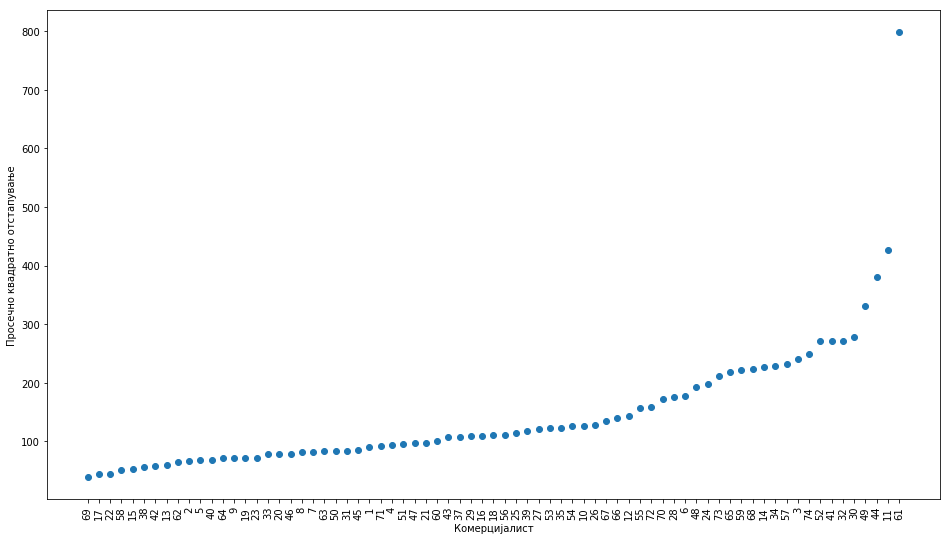

In [18]:
plt.figure(figsize=(16, 9))
plt.plot(deviations, 'o')

# plt.title('Отстапување на секој запис (вработен, продавница, месец)')
plt.xticks(deviations.index, rotation=90)
plt.xlabel('Комерцијалист')
plt.ylabel('Просечно квадратно отстапување')

plt.savefig(f'{plot_out}/Отстапување на секој запис')
plt.show()

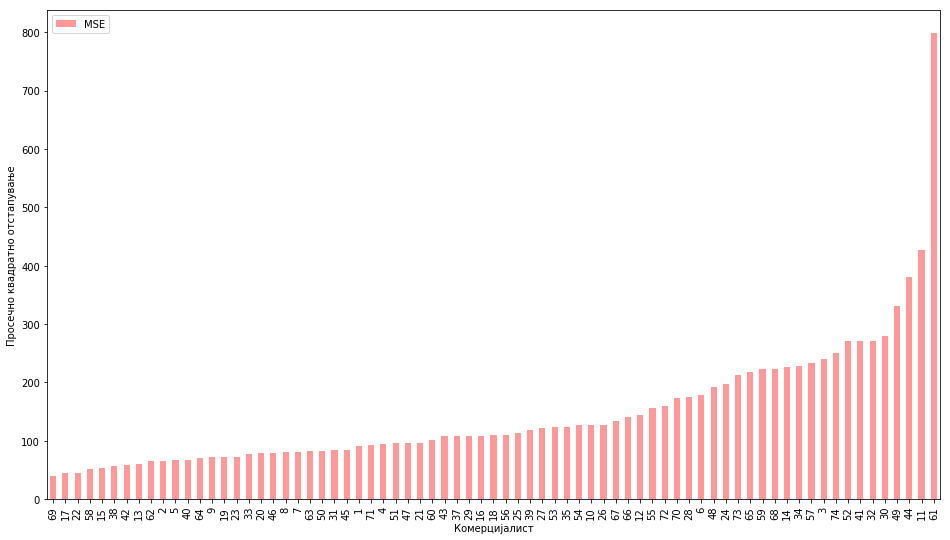

In [23]:
plt.figure(figsize=(16, 9))
ax = plt.axes()

deviations.plot.bar(color='red', alpha=0.4, ax=ax)

# plt.title('Просечно квадратно отстапување на секој од вработените на месечно ниво')
plt.xlabel('Комерцијалист')
plt.ylabel('Просечно квадратно отстапување')
plt.legend(loc=2)

plt.savefig(f'{plot_out}/Просечно квадратно отстапување на секој од вработените на месечно ниво')
plt.show()

#### Вкупен број на записи во еден месец

In [12]:
entries = list()

for e in tree.keys():
    for c in tree[e].keys():
        for m in tree[e][c].keys():
            entries.append(len(tree[e][c][m]))
            
entries = np.array(entries)

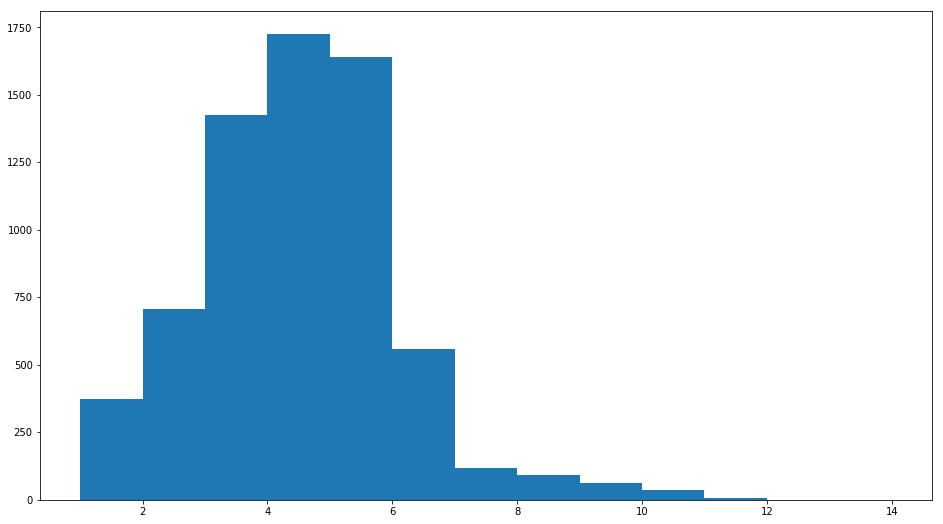

In [13]:
plt.figure(figsize=(16, 9))
plt.hist(entries, bins=len(set(entries)))
plt.show()

In [14]:
entries_series = dict()

for entry in set(entries):
    entries_series[entry] = (entries == entry).sum()

entries_series = pd.Series(entries_series).sort_index()
entries_series

1      375
2      708
3     1424
4     1726
5     1641
6      560
7      117
8       92
9       61
10      36
11       8
12       1
14       1
dtype: int64